### **Importing packages**


In [ ]:
import pandas as pd
import numpy as np
import os
import re
import seaborn as sns

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from nltk.corpus import wordnet
nltk.download("punkt")
nltk.download("stopwords")
from nltk.corpus import stopwords

import string
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from plotly import tools
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.figure_factory as ff

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.theonion.com/thirtysomething-scien...,thirtysomething scientists unveil doomsday clo...,1
1,https://www.huffingtonpost.com/entry/donna-edw...,dem rep. totally nails why congress is falling...,0
2,https://www.huffingtonpost.com/entry/eat-your-...,eat your veggies: 9 deliciously different recipes,0
3,https://local.theonion.com/inclement-weather-p...,inclement weather prevents liar from getting t...,1
4,https://www.theonion.com/mother-comes-pretty-c...,mother comes pretty close to using word 'strea...,1


In [ ]:
df.columns
df.shape

(28619, 3)

In [ ]:
print(df['is_sarcastic'].value_counts())

0    14985
1    13634
Name: is_sarcastic, dtype: int64


### Data Visulaisation

In [ ]:
labels = ['Sarcasm', 'Not Sarcasm']
values = [df['is_sarcastic'].sum(), len(df) - df['is_sarcastic'].sum()]

trace0 = go.Bar(x = [labels[1]], y = [values[1]], name = 'No Sarcasm')
trace1 = go.Bar(x = [labels[0]], y = [values[0]], marker= {'color': '#00cc66'} , name = 'Sarcasm')


data = [trace0, trace1]

layout = go.Layout(title = 'Number of Sarcastic Articles',
                   width = 800,
                   height = 500,
                  yaxis= dict(title = 'Number of articles'),)

fig = go.Figure(data, layout)

pyo.offline.iplot(fig)

## **Data Cleansing**

In [ ]:

#Function to remove non ascii characters

def rem_non_ascii(data):
  stripped = (c for c in data if 0 < ord(c) < 127) 
  return ''.join(stripped)

In [ ]:
#Lemmatisation
lemmatizer = WordNetLemmatizer()

def nltk2wn_tag(nltk_tag):
  if nltk_tag.startswith('J'):
    return wordnet.ADJ
  elif nltk_tag.startswith('V'):
    return wordnet.VERB
  elif nltk_tag.startswith('N'):
    return wordnet.NOUN
  elif nltk_tag.startswith('R'):
    return wordnet.ADV
  else:          
    return None
  
def lemmatize_sentence(text):
  nltk_tagged = nltk.pos_tag(nltk.word_tokenize(text))  
  wn_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)
  res_words = []
  for word, tag in wn_tagged:
    if tag is None:            
      res_words.append(word)
    else:
      res_words.append(lemmatizer.lemmatize(word, tag))
  return " ".join(res_words)

In [ ]:
df.headline[1]

'dem rep. totally nails why congress is falling short on gender, racial equality'

In [ ]:
#counting unwanted words
import re
count_url_re = 0
count_punc_re = 0
count_num_re = 0
count_mention_re = 0
count_aplha_num_re = 0

#df2= df.lower() 
for i in range(len(df.headline)):
  no_url_re = re.findall('https?://(www.)?\w+\.\w+(/\w+)*/?',df.headline[i])
  count_url_re += len(no_url_re)
  punc_re = re.findall('[%s]',df.headline[i]) 
  count_punc_re += len(punc_re)
  num_re = re.findall('(\\d+)', df.headline[i])
  count_num_re += len(num_re)
  mention_re = re.findall('@(\w+)', df.headline[i])
  count_mention_re += len(mention_re)
  alpha_num_re = re.findall("^[a-z0-9_.]+$", df.headline[i])
  count_aplha_num_re += len(alpha_num_re)

print ("Count of url in headline:", count_url_re)
print ("Count of punctuation in headline:",count_punc_re)
print ("Count of numbers in headline:",count_num_re)
print ("Count of mentions in headline:",count_mention_re)
print ("Count of alphanum in headline:",count_aplha_num_re)

Count of url in headline: 0
Count of punctuation in headline: 107328
Count of numbers in headline: 4980
Count of mentions in headline: 1
Count of alphanum in headline: 0


In [ ]:
#Definition to remove punctuation 
def remove_features(data_str): # compile regex
    punc_re = re.compile('[%s]' % re.escape(string.punctuation)) 
    num_re = re.compile('(\\d+)')
    #mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
    # convert to lowercase
    data_str = data_str.lower()
    # remove hyperlinks
    #data_str = url_re.sub(' ', data_str)
    # remove @mentions
    #data_str = mention_re.sub(' ', data_str)
    # remove puncuation
    data_str = punc_re.sub(' ', data_str)
    # remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
    # remove non a-z 0-9 characters and words shorter than 1 characters 
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = word 
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = cleaned_str + ' ' + word 
            else:
                cleaned_str += ' '
        list_pos += 1
    
    return " ".join(cleaned_str.split())

In [ ]:
# Removing stop words


def remove_stops(data_str):
    # expects a string
    stops = set(stopwords.words("english"))
    list_pos = 0
    cleaned_str = ''
    text = data_str.split()
    for word in text:
        if word not in stops:
            # rebuild cleaned_str
            if list_pos == 0:
                cleaned_str = word
            else:
                cleaned_str = cleaned_str + ' ' + word
            list_pos += 1
    return cleaned_str


In [ ]:
#Applying functions for cleaning data in the headline column of dataset

data = []
for i in range(len(df.headline)):
  res = remove_features(df.headline[i])
  res1 = rem_non_ascii(res)
  res2 = remove_stops(res1)
  res3 = lemmatize_sentence(res2)
  data.append(res3)
  

In [ ]:
data

['thirtysomething scientist unveil doomsday clock hair loss',
 'dem rep totally nails congress fall short gender racial equality',
 'eat veggie deliciously different recipe',
 'inclement weather prevents liar get work',
 'mother come pretty close use word stream correctly',
 'white inheritance',
 'way file tax less stress',
 'richard branson global warm donation nearly much cost fail balloon trip',
 'shadow government get large meet marriott conference room',
 'lot parent know scenario',
 'lesbian consider father indiana amaze one',
 'amanda peet tell daughter sex special hug',
 'know regard current treatment ebola',
 'chris christie suggest hillary clinton blame boko haram kidnapping hundred schoolgirls',
 'ford develop new suv run purely gasoline',
 'uber ceo travis kalanick step trump economic advisory council',
 'area boy enters jump touch top doorway phase',
 'area man travel gurney',
 'leave person disability behind',
 'lin manuel miranda would like remind put phone away',
 'jour

### Adding the Clean headline data as a new column to Dataset

In [ ]:
df['clean_headline'] = data

In [ ]:
allWords_df = df['clean_headline'].str.split(expand = True).unstack().value_counts()
allWords_df = pd.DataFrame(allWords_df).reset_index()

In [ ]:
pip install plotly

In [ ]:
trace0 = go.Bar(x = allWords_df['index'][0:50] , y = allWords_df[0][0:50], marker = dict(color = allWords_df[0]
                                                                                   , colorscale = 'Portland')
                                                                                , name = 'Top 50 Frequent Headline Words')

data = [trace0]

layout = go.Layout(title = 'Most Frequent Words',
                   width = 950,
                   height = 600,
                   xaxis = dict(title = 'Words', nticks = 50),
                  yaxis= dict(title = 'Count'),)

fig = go.Figure(data, layout)

pyo.offline.iplot(fig)

In [ ]:

import numpy as np

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

sar_acc_tar = df['is_sarcastic'].value_counts()
labels = ['Acclaim', 'Sarcastic']
sizes = (np.array((sar_acc_tar / sar_acc_tar.sum())*100))
colors = ['#58D68D', '#9B59B6']

trace = go.Pie(labels=labels, values=sizes, opacity = 0.8, hoverinfo='label+percent',
               marker=dict(colors=colors, line=dict(color='#FFFFFF', width=2)))
layout = go.Layout(
    title='Sarcastic Vs Acclaim'
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
pyo.offline.iplot(fig)
#iplot(fig, filename="Sa_Ac")

## **Creating Word Clouds**

In [ ]:
wc_string = df['clean_headline'].str.cat(sep=' ')

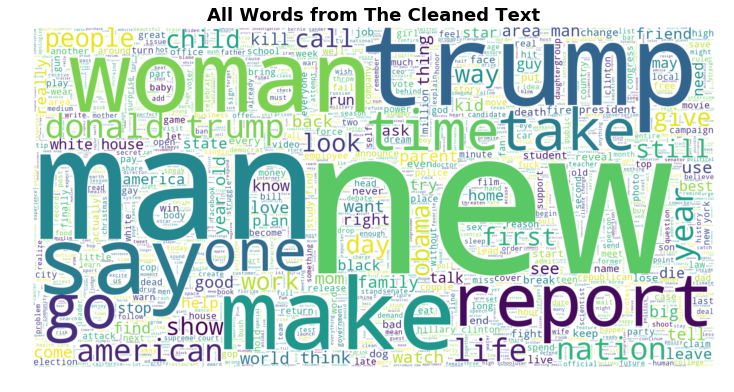

In [ ]:
wc = WordCloud(width=1600, height=800,background_color="white", max_words=2000).generate(wc_string)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('All Words from The Cleaned Text', fontsize=18, fontweight = 'bold')
plt.show()

**WordCloud for Non-Sarcastic Headlines**

In [ ]:
non_sarcastic = df[df.is_sarcastic == 0]['clean_headline'].str.cat(sep=' ')

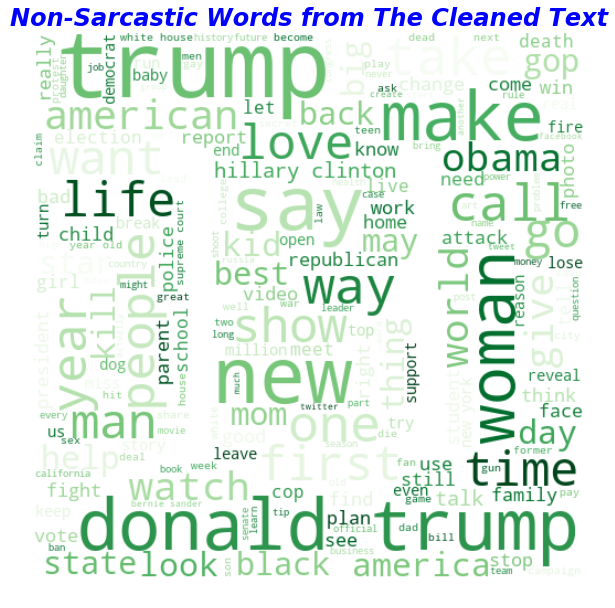

In [ ]:
huff_mask = np.array(Image.open("the-huffington-post.jpg"))
wc = WordCloud(width=1600, height=800,background_color="white", colormap="Greens",mask=huff_mask).generate(non_sarcastic)
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Non-Sarcastic Words from The Cleaned Text', fontsize=24, fontstyle = 'italic', color = 'blue', fontweight = 'bold')
plt.show()

**WordCloud for Sarcastic Headlines**

In [ ]:
sarcastic = df[df.is_sarcastic == 1]['clean_headline'].str.cat(sep=' ')

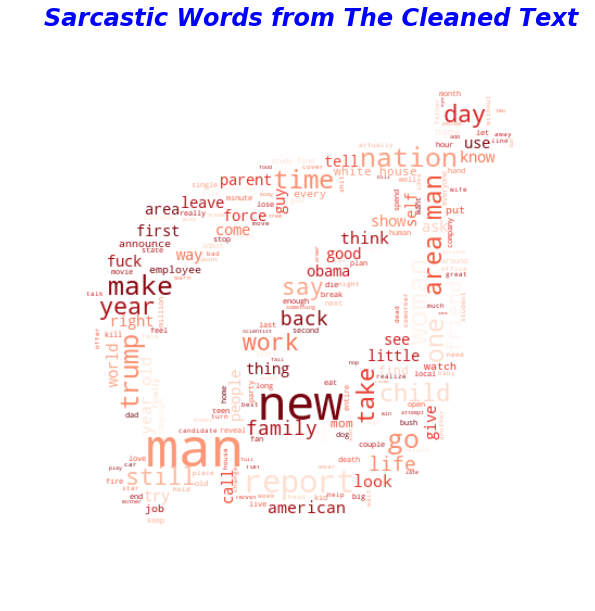

In [ ]:
onion_mask = np.array(Image.open("onion.jpg"))
wc = WordCloud(width=1600, height=800,background_color="white", colormap="Reds",mask=onion_mask).generate(sarcastic)
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Sarcastic Words from The Cleaned Text', fontsize=24, fontstyle = 'italic', color = 'blue', fontweight = 'bold')
plt.show()

## Feature Extraction

In [ ]:

#Total number of words used

df['nb_words'] = df.headline.apply(lambda x:len(x.split()))

#Number of unique words

df['nb_unique_words'] = df.headline.apply(lambda x: len(set(x.split())))

#Total number of characters used

df['nb_char'] = df.headline.apply(lambda x:len(x))

#Total number of unique characters used

df['nb_unique_char'] = df.clean_headline.apply(lambda x:len(set(x.split())))

In [ ]:
#Total number of punctuation used

import string

def num_punc(text):
  x =0
  for i in text.split():
     if i in list(string.punctuation):
       x = x+1 
  return x

df['nb_puctuation'] = df.headline.apply(lambda x: num_punc(x))

In [ ]:
# Total number of stop words

import nltk, os, re
from nltk.corpus import stopwords
stopset = stopwords.words('english')

def num_stpwrds(text):
  x=0 
  for i in text.split():
    if i in stopset:
      x =x+1
  return x

df['nb_stpwrds'] = df.headline.apply(lambda x: num_stpwrds(x))

In [ ]:
# Average length of words

import numpy as np

def length(text):
  return(np.mean([len(w) for w in text.split()]))

df['nb_len_wrd'] = df.headline.apply(lambda x:length(x))

In [ ]:
#Number of most frequent words

tokens = nltk.word_tokenize(''.join(df.headline))
frequent = nltk.FreqDist(tokens)
frequent.most_common(15)


[('to', 8996),
 ('of', 6241),
 ("'s", 5058),
 ('in', 4430),
 ('the', 4353),
 (',', 3896),
 ('for', 3576),
 ("'", 3109),
 ('a', 2846),
 (':', 2650),
 ('on', 2544),
 ('and', 1978),
 ('with', 1922),
 ('is', 1654),
 ('at', 1297)]

In [ ]:
#Removing stopwords and punctuation

stopword = stopwords.words('english')

for sym in string.punctuation:
    del frequent[sym]
    
for word in stopword:
    del frequent[word]
    
frequent.most_common(15)

[("'s", 5058),
 ('trump', 1234),
 ('new', 1185),
 ("n't", 1132),
 ('man', 866),
 ('one', 489),
 ('like', 416),
 ('says', 414),
 ('get', 409),
 ('first', 387),
 ('still', 363),
 ('people', 345),
 ('make', 342),
 ('could', 328),
 ('woman', 313)]

In [ ]:
## NUMBER OF WORDS CONTAIN OUT OF MOST COMMON 100 WORDS 

freq_words = list(dict(frequent.most_common()[:100]).keys())

def freq(text):
    return(len([w for w in text.split() if w in freq_words]))
df['nb_freq_words'] = df.headline.apply(lambda x: freq(x))

In [ ]:
## AVERAGE OF FREQ TERMS WITH TOTAL WORDS USED


def freq(text):
    return(len([w for w in text.split() if w in freq_words])/len(text.split()))
  
df['avg_freq_word'] = df.headline.apply(lambda x: freq(x))

In [ ]:
df.describe()

,is_sarcastic,nb_words,nb_unique_words,nb_char,nb_unique_char,nb_puctuation,nb_stpwrds,nb_len_wrd,nb_freq_words,avg_freq_word
count,28619.000000,28619.000000,28619.000000,28619.000000,28619.000000,28619.000000,28619.000000,28619.000000,28619.000000,28619.000000
mean,0.476397,10.049967,9.913624,62.308571,7.094937,0.006429,2.743807,5.391303,0.947063,0.091500
std,0.499451,3.388307,3.252229,20.726483,2.421116,0.082508,1.805130,0.973804,1.028506,0.098200
min,0.000000,2.000000,1.000000,7.000000,0.000000,0.000000,0.000000,2.333333,0.000000,0.000000
25%,0.000000,8.000000,8.000000,49.000000,5.000000,0.000000,1.000000,4.727273,0.000000,0.000000
50%,0.000000,10.000000,10.000000,62.000000,7.000000,0.000000,2.000000,5.300000,1.000000,0.083333
75%,1.000000,12.000000,12.000000,75.000000,9.000000,0.000000,4.000000,6.000000,1.000000,0.142857
max,1.000000,151.000000,113.000000,926.000000,96.000000,3.000000,45.000000,13.333333,8.000000,1.000000


In [ ]:
df.head(5)

,article_link,headline,is_sarcastic,clean_headline,nb_words,nb_unique_words,nb_char,nb_unique_char,nb_puctuation,nb_stpwrds,nb_len_wrd,nb_freq_words,avg_freq_word
0,https://www.theonion.com/thirtysomething-scien...,thirtysomething scientists unveil doomsday clo...,1,thirtysomething scientist unveil doomsday cloc...,8,8,61,7,0,1,6.750000,0,0.00
1,https://www.huffingtonpost.com/entry/donna-edw...,dem rep. totally nails why congress is falling...,0,dem rep totally nails congress fall short gend...,13,13,79,10,0,3,5.153846,0,0.00
2,https://www.huffingtonpost.com/entry/eat-your-...,eat your veggies: 9 deliciously different recipes,0,eat veggie deliciously different recipe,7,7,49,5,0,1,6.142857,0,0.00
3,https://local.theonion.com/inclement-weather-p...,inclement weather prevents liar from getting t...,1,inclement weather prevents liar get work,8,8,52,6,0,2,5.625000,2,0.25
4,https://www.theonion.com/mother-comes-pretty-c...,mother comes pretty close to using word 'strea...,1,mother come pretty close use word stream corre...,9,9,61,8,0,1,5.888889,0,0.00


# ML Models

In [ ]:
#Import packages required for Models
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
import xgboost as xgb

## Creating Train and Test Dataset 

In [ ]:
label_y = df.is_sarcastic

In [ ]:
df_clean = df.drop('is_sarcastic',axis=1)

In [ ]:
seed = 777
X_train, X_test, y_train, y_test = train_test_split(df_clean, label_y, test_size=0.3, random_state=seed)

In [ ]:
print("X_train Shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

X_train Shape: (20033, 12) y_train shape: (20033,)
X_test shape: (8586, 12) y_test shape: (8586,)


## Dataset for Extracted Feature Model

In [ ]:
df_1 = X_train.drop(['article_link','headline','clean_headline'],axis=1)
df_1.head()

,nb_words,nb_unique_words,nb_char,nb_unique_char,nb_puctuation,nb_stpwrds,nb_len_wrd,nb_freq_words,avg_freq_word
17329,8,8,49,6,0,2,5.250,0,0.000000
17744,4,4,23,3,0,0,5.000,0,0.000000
12825,6,6,35,5,0,1,5.000,1,0.166667
13901,10,10,54,7,0,3,4.500,0,0.000000
21680,8,8,66,6,0,2,7.375,0,0.000000


# Model on Extracted Features

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_corr = df.drop(['article_link','headline','clean_headline'],axis=1)
df_corr = pd.DataFrame(df_corr)
corr = df_corr.corr()


In [ ]:
corr

,is_sarcastic,nb_words,nb_unique_words,nb_char,nb_unique_char,nb_puctuation,nb_stpwrds,nb_len_wrd,nb_freq_words,avg_freq_word
is_sarcastic,1.000000,0.072512,0.076254,0.139099,0.200187,-0.031084,-0.096509,0.154334,0.066782,0.050037
nb_words,0.072512,1.000000,0.990785,0.911442,0.806830,0.032349,0.714844,-0.280774,0.358001,0.082615
nb_unique_words,0.076254,0.990785,1.000000,0.909765,0.816897,0.030588,0.694116,-0.269632,0.362622,0.086179
nb_char,0.139099,0.911442,0.909765,1.000000,0.884717,0.011120,0.493732,0.108271,0.262058,0.013141
nb_unique_char,0.200187,0.806830,0.816897,0.884717,1.000000,0.011813,0.216786,0.088743,0.313416,0.097453
nb_puctuation,-0.031084,0.032349,0.030588,0.011120,0.011813,1.000000,-0.010290,-0.045050,-0.012460,-0.019506
nb_stpwrds,-0.096509,0.714844,0.694116,0.493732,0.216786,-0.010290,1.000000,-0.524432,0.208121,0.002219
nb_len_wrd,0.154334,-0.280774,-0.269632,0.108271,0.088743,-0.045050,-0.524432,1.000000,-0.233339,-0.172962
nb_freq_words,0.066782,0.358001,0.362622,0.262058,0.313416,-0.012460,0.208121,-0.233339,1.000000,0.902782
avg_freq_word,0.050037,0.082615,0.086179,0.013141,0.097453,-0.019506,0.002219,-0.172962,0.902782,1.000000


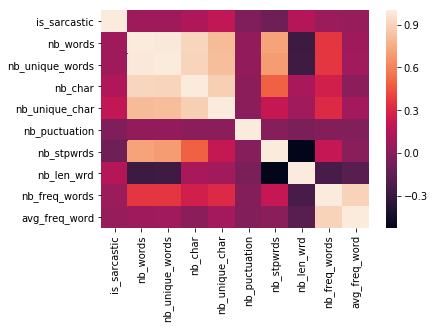

In [ ]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(df_1, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred_train = model.predict(df_1)

In [ ]:
accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 64.76%


In [ ]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

In [ ]:
results = confusion_matrix(y_train, y_pred_train) 
print("Confusion Matrix :")
print(results) 
print ("Accuracy Score :",accuracy_score(y_train, y_pred_train))
print ("Report : ")
print (classification_report(y_train, y_pred_train))

Confusion Matrix :
[[8044 2483]
 [4576 4930]]
Accuracy Score : 0.6476314081765088
Report : 
              precision    recall  f1-score   support

           0       0.64      0.76      0.70     10527
           1       0.67      0.52      0.58      9506

    accuracy                           0.65     20033
   macro avg       0.65      0.64      0.64     20033
weighted avg       0.65      0.65      0.64     20033



## Cross Validation and Standardization

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

estimator = XGBClassifier()
pipe1 = Pipeline([('scaler', StandardScaler()), ('classifier', estimator)])


In [ ]:
pipe1.fit(df_1, y_train, classifier__eval_metric='auc')

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [ ]:
y_pred_train1 = pipe1.predict(df_1)

In [ ]:
accuracy = accuracy_score(y_train, y_pred_train1)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 64.76%


In [ ]:
results_1 = confusion_matrix(y_train, y_pred_train1) 
print("Confusion Matrix :")
print(results_1) 
print ("Accuracy Score :",accuracy_score(y_train, y_pred_train1))
print ("Report : ")
print (classification_report(y_train, y_pred_train1))

Confusion Matrix :
[[8044 2483]
 [4576 4930]]
Accuracy Score : 0.6476314081765088
Report : 
              precision    recall  f1-score   support

           0       0.64      0.76      0.70     10527
           1       0.67      0.52      0.58      9506

    accuracy                           0.65     20033
   macro avg       0.65      0.64      0.64     20033
weighted avg       0.65      0.65      0.64     20033



### The accuracy reduces upon application of cross validation on XGBoost Classifier

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe1,df_1,y_train,cv=10, scoring= 'roc_auc')

In [ ]:
scores.mean()

0.6991497764523406

In [ ]:
from sklearn.model_selection import cross_val_predict

y_pred_train2 = cross_val_predict(pipe1,df_1, y_train, cv=10)

In [ ]:
from sklearn import metrics
accuracy = accuracy_score(y_train, y_pred_train2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 64.06%


In [ ]:
results_2 = confusion_matrix(y_train, y_pred_train2) 
print("Confusion Matrix :")
print(results_2) 
print ("Accuracy Score :",accuracy_score(y_train, y_pred_train2))
print ("Report : ")
print (classification_report(y_train, y_pred_train2))

Confusion Matrix :
[[7929 2598]
 [4601 4905]]
Accuracy Score : 0.6406429391504018
Report : 
              precision    recall  f1-score   support

           0       0.63      0.75      0.69     10527
           1       0.65      0.52      0.58      9506

    accuracy                           0.64     20033
   macro avg       0.64      0.63      0.63     20033
weighted avg       0.64      0.64      0.64     20033



## Testing the best model (XGBoost Classifier) in Test Dataset

In [ ]:
df_1_test = X_test.drop(['article_link','headline','clean_headline'],axis=1)
df_1_test.head()

,nb_words,nb_unique_words,nb_char,nb_unique_char,nb_puctuation,nb_stpwrds,nb_len_wrd,nb_freq_words,avg_freq_word
1043,9,9,65,5,0,4,6.333333,0,0.0
25378,10,10,66,8,0,1,5.700000,1,0.1
14695,10,10,51,6,0,5,4.200000,1,0.1
28448,11,11,69,9,0,2,5.363636,0,0.0
13853,11,11,51,6,1,4,3.727273,0,0.0


In [ ]:
y_test_pred = model.predict(df_1_test)

In [ ]:
final_results = confusion_matrix(y_test, y_test_pred) 
print("Confusion Matrix :")
print(final_results) 
print ("Accuracy Score :",accuracy_score(y_test, y_test_pred))
print ("Report : ")
print (classification_report(y_test, y_test_pred))

Confusion Matrix :
[[3418 1040]
 [2034 2094]]
Accuracy Score : 0.6419753086419753
Report : 
              precision    recall  f1-score   support

           0       0.63      0.77      0.69      4458
           1       0.67      0.51      0.58      4128

    accuracy                           0.64      8586
   macro avg       0.65      0.64      0.63      8586
weighted avg       0.65      0.64      0.64      8586



## For Ensemble Model get the prediction of y_test

In [ ]:
df_1_test =X_test.drop(['article_link','headline','clean_headline'],axis=1)

In [ ]:
y_test_ensemble = pipe1.predict_proba(df_1_test)

In [ ]:
y_test_ensemble

array([[0.8004955 , 0.19950452],
       [0.54261124, 0.4573888 ],
       [0.72479767, 0.27520233],
       ...,
       [0.467205  , 0.532795  ],
       [0.59264946, 0.4073505 ],
       [0.58699477, 0.4130052 ]], dtype=float32)

## Model on Text Features Dataset

## Create Dataset for Text Data using X_train and y_train

In [ ]:
df_2 = X_train.loc[:,'clean_headline']
#df_1.drop('is_sarcastic', axis=1, inplace=True)
print('Txt_Feature Dataset:',df_2.shape)
print('Txt_Feature Label:',y_train.shape)
df_2.head()

Txt_Feature Dataset: (20033,)
Txt_Feature Label: (20033,)


17329            sinatra hope reagan deadlocked race grave
17744                                    nature trust part
12825                        god admit never create gerbil
13901         michael jackson depose king pop hitless coup
21680    republican outrage redtube censor conservative...
Name: clean_headline, dtype: object

## Dividing dataset in Train and validation dataset

In [ ]:
seed = 666
X_train_txt, X_val_txt, y_train_txt, y_val_txt = train_test_split(df_2, y_train, test_size=0.2, random_state=seed)
print("X_train_txt shape:", X_train_txt.shape, "y_train_txt shape:", y_train_txt.shape)
print("X_val_txt shape:", X_val_txt.shape, "y_val_txt shape:", y_val_txt.shape)

X_train_txt shape: (16026,) y_train_txt shape: (16026,)
X_val_txt shape: (4007,) y_val_txt shape: (4007,)


In [ ]:
X_train_txt.head(3)

22092              senate bill aim lock hacker connect car
17145    mom really gun befriend babysitter weekly minu...
1039     cnn producer hunt sad look fuck convention but...
Name: clean_headline, dtype: object

In [ ]:
X_train_txt.head(2)
y_train_txt.head(2)

22092    0
17145    1
Name: is_sarcastic, dtype: int64

## Using NaiveBayesClassifier

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import BernoulliNB

text_clf = Pipeline([('vect', CountVectorizer()),('tfidf',TfidfTransformer()),('clf',BernoulliNB())])

In [ ]:
text_clf.fit(X_train_txt,y_train_txt) 

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                             fit_prior=True))],
         verbose=False)

In [ ]:
predict_text = text_clf.predict(X_train_txt)

In [ ]:
np.mean(predict_text == y_train_txt) 

0.9027829776613003

In [ ]:
results_nb_1 = confusion_matrix(y_train_txt, predict_text) 
print("Confusion Matrix :")
print(results_nb_1) 
print ("Accuracy Score :",accuracy_score(y_train_txt, predict_text))
print ("Report : ")
print (classification_report(y_train_txt, predict_text))

Confusion Matrix :
[[7867  560]
 [ 998 6601]]
Accuracy Score : 0.9027829776613003
Report : 
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      8427
           1       0.92      0.87      0.89      7599

    accuracy                           0.90     16026
   macro avg       0.90      0.90      0.90     16026
weighted avg       0.90      0.90      0.90     16026



In [ ]:
predict_text_val = text_clf.predict(X_val_txt)
np.mean(predict_text_val == y_val_txt) 

0.7951085600199651

In [ ]:
results_nb = confusion_matrix(y_val_txt, predict_text_val) 
print("Confusion Matrix :")
print(results_nb) 
print ("Accuracy Score :",accuracy_score(y_val_txt, predict_text_val))
print ("Report : ")
print (classification_report(y_val_txt, predict_text_val))

Confusion Matrix :
[[1820  280]
 [ 541 1366]]
Accuracy Score : 0.7951085600199651
Report : 
              precision    recall  f1-score   support

           0       0.77      0.87      0.82      2100
           1       0.83      0.72      0.77      1907

    accuracy                           0.80      4007
   macro avg       0.80      0.79      0.79      4007
weighted avg       0.80      0.80      0.79      4007



## Using XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier
text_xgb_clf = Pipeline([('vect', CountVectorizer()),('tfidf',TfidfTransformer()),('clf',XGBClassifier())])

In [ ]:
text_xgb_clf.fit(X_train_txt,y_train_txt)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing

In [ ]:
predict_text_xgb = text_xgb_clf.predict(X_train_txt)

In [ ]:
np.mean(predict_text_xgb == y_train_txt) 

0.6855734431548733

In [ ]:
results_xgb = confusion_matrix(y_train_txt, predict_text_xgb) 
print("Confusion Matrix :")
print(results_xgb) 
print ("Accuracy Score :",accuracy_score(y_train_txt, predict_text_xgb))
print ("Report : ")
print (classification_report(y_train_txt, predict_text_xgb))

Confusion Matrix :
[[7783  644]
 [4395 3204]]
Accuracy Score : 0.6855734431548733
Report : 
              precision    recall  f1-score   support

           0       0.64      0.92      0.76      8427
           1       0.83      0.42      0.56      7599

    accuracy                           0.69     16026
   macro avg       0.74      0.67      0.66     16026
weighted avg       0.73      0.69      0.66     16026



In [ ]:
predict_text_xgb_1 = text_xgb_clf.predict(X_val_txt)

In [ ]:
np.mean(predict_text_xgb_1 == y_val_txt) 

0.6753181931619665

In [ ]:
results_xgb_1 = confusion_matrix(y_val_txt, predict_text_xgb_1) 
print("Confusion Matrix :")
print(results_xgb_1) 
print ("Accuracy Score :",accuracy_score(y_val_txt, predict_text_xgb_1))
print ("Report : ")
print (classification_report(y_val_txt, predict_text_xgb_1))

Confusion Matrix :
[[1945  155]
 [1146  761]]
Accuracy Score : 0.6753181931619665
Report : 
              precision    recall  f1-score   support

           0       0.63      0.93      0.75      2100
           1       0.83      0.40      0.54      1907

    accuracy                           0.68      4007
   macro avg       0.73      0.66      0.64      4007
weighted avg       0.73      0.68      0.65      4007



## Logistic Regression for the Model

In [ ]:
from sklearn.linear_model import LogisticRegression

text_Logreg_clf = Pipeline([('vect', CountVectorizer()),('tfidf',TfidfTransformer()),('clf',LogisticRegression())])
text_Logreg_clf.fit(X_train_txt,y_train_txt)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
  

In [ ]:
predict_text_logreg = text_Logreg_clf.predict(X_train_txt)
np.mean(predict_text_logreg == y_train_txt) 

0.8846873830026207

In [ ]:
results_logreg = confusion_matrix(y_train_txt, predict_text_logreg) 
print("Confusion Matrix :")
print(results_logreg) 
print ("Accuracy Score :",accuracy_score(y_train_txt, predict_text_logreg))
print ("Report : ")
print (classification_report(y_train_txt, predict_text_logreg))

Confusion Matrix :
[[7675  752]
 [1096 6503]]
Accuracy Score : 0.8846873830026207
Report : 
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      8427
           1       0.90      0.86      0.88      7599

    accuracy                           0.88     16026
   macro avg       0.89      0.88      0.88     16026
weighted avg       0.89      0.88      0.88     16026



In [ ]:
predict_text_logreg_1 = text_Logreg_clf.predict(X_val_txt)

In [ ]:
np.mean(predict_text_logreg_1 == y_val_txt) 

0.7758921886698278

In [ ]:
results_logreg_1 = confusion_matrix(y_val_txt, predict_text_logreg_1) 
print("Confusion Matrix :")
print(results_logreg_1)   
print ("Accuracy Score :",accuracy_score(y_val_txt, predict_text_logreg_1))
print ("Report : ")
print (classification_report(y_val_txt, predict_text_logreg_1))

Confusion Matrix :
[[1737  363]
 [ 535 1372]]
Accuracy Score : 0.7758921886698278
Report : 
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      2100
           1       0.79      0.72      0.75      1907

    accuracy                           0.78      4007
   macro avg       0.78      0.77      0.77      4007
weighted avg       0.78      0.78      0.78      4007



## We Find Naive Bayes Algorithm as Winner for our model

In [ ]:
df_2_test = X_test.loc[:,'clean_headline']
df_2_test.shape

(8586,)

In [ ]:
predict_text_nb_test = text_clf.predict(df_2_test)
np.mean(predict_text_nb_test == y_test) 

0.7846494293035173

In [ ]:
final_results = confusion_matrix(y_test, predict_text_nb_test) 
print("Confusion Matrix :")
print(final_results) 
print ("Accuracy Score :",accuracy_score(y_test, predict_text_nb_test))
print ("Report : ")
print (classification_report(y_test, predict_text_nb_test))

Confusion Matrix :
[[3762  696]
 [1153 2975]]
Accuracy Score : 0.7846494293035173
Report : 
              precision    recall  f1-score   support

           0       0.77      0.84      0.80      4458
           1       0.81      0.72      0.76      4128

    accuracy                           0.78      8586
   macro avg       0.79      0.78      0.78      8586
weighted avg       0.79      0.78      0.78      8586



## Dataset for ensemble Method

In [ ]:
df_2_test =X_test.loc[:,'clean_headline']

In [ ]:
predict_text_ensemble = text_clf.predict_proba(df_2_test)

In [ ]:
predict_text_ensemble

array([[0.79568934, 0.20431066],
       [0.13156662, 0.86843338],
       [0.81870905, 0.18129095],
       ...,
       [0.48810727, 0.51189273],
       [0.97116292, 0.02883708],
       [0.95323631, 0.04676369]])

## Ensemble Model

## Building  Dataset by taking mean of probability  arrays of both Text Feature and Feature Extraction

In [ ]:
emsemble_array = (np.array(y_test_ensemble) + np.array(predict_text_ensemble)) / 2.0

In [ ]:
emsemble_array

array([[0.80484128, 0.19515873],
       [0.34576665, 0.65423333],
       [0.76926433, 0.23073567],
       ...,
       [0.4849751 , 0.5150249 ],
       [0.78045112, 0.21954888],
       [0.77090929, 0.22909071]])

In [ ]:
ensemble_dataset = pd.DataFrame({'No_Sarcasm': emsemble_array[:, 0], 'With_sarcasm': emsemble_array[:, 1]})

In [ ]:
ensemble_dataset.head(1)

,No_Sarcasm,With_sarcasm
0,0.804841,0.195159


In [ ]:
def flag(c):
  if c['No_Sarcasm'] > c['With_sarcasm'] :
    return 0
  elif c['No_Sarcasm'] == c['With_sarcasm']:
    return 'undefined'
  else:
    return 1

In [ ]:
ensemble_dataset['flag'] = ensemble_dataset.apply(flag, axis=1)

In [ ]:
ensemble_dataset.head(10)

,Index,No_Sarcasm,With_sarcasm,flag
0,0,0.804841,0.195159,0
1,1,0.345767,0.654233,1
2,2,0.769264,0.230736,0
3,3,0.497621,0.502379,1
4,4,0.770336,0.229664,0
5,5,0.561589,0.438411,0
6,6,0.306873,0.693127,1
7,7,0.468584,0.531416,1
8,8,0.206494,0.793506,1
9,9,0.625709,0.374291,0


In [ ]:
ensemble_dataset.insert(loc=0, column='Index', value=np.arange(len(ensemble_dataset)))

In [ ]:
y_test_1 = pd.DataFrame(y_test)

In [ ]:
y_test_1.insert(loc=0, column='Index', value=np.arange(len(y_test_1)))

In [ ]:
y_test_1.dtypes

Index           int64
is_sarcastic    int64
dtype: object

In [ ]:
ensemble_dataset.dtypes

Index             int64
No_Sarcasm      float64
With_sarcasm    float64
flag              int64
dtype: object

## Combining predicted class and actual class in same dataset.

In [ ]:
mergedStuff = pd.merge(ensemble_dataset, y_test_1, on=['Index'], how='inner')
mergedStuff.head()

,Index,No_Sarcasm,With_sarcasm,flag,is_sarcastic
0,0,0.804841,0.195159,0,1
1,1,0.345767,0.654233,1,1
2,2,0.769264,0.230736,0,0
3,3,0.497621,0.502379,1,1
4,4,0.770336,0.229664,0,0


## Evaluating performance by calculating difference between the Predicted Class and Actual Class

In [ ]:
np.mean(mergedStuff.flag == mergedStuff.is_sarcastic)

0.8038667598416026

In [ ]:
ensemble_results = confusion_matrix(mergedStuff.flag, mergedStuff.is_sarcastic) 
print("Confusion Matrix :")
print(ensemble_results) 
print ("Accuracy Score :",accuracy_score(mergedStuff.flag, mergedStuff.is_sarcastic))
print ("Report : ")
print (classification_report(mergedStuff.flag, mergedStuff.is_sarcastic))

Confusion Matrix :
[[3891 1117]
 [ 567 3011]]
Accuracy Score : 0.8038667598416026
Report : 
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      5008
           1       0.73      0.84      0.78      3578

    accuracy                           0.80      8586
   macro avg       0.80      0.81      0.80      8586
weighted avg       0.81      0.80      0.81      8586

